In [1]:
import anndata as ad
import crested
import numpy as np

2025-08-06 11:01:07.555446: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 11:01:08.158980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754503268.381167  135944 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754503268.452465  135944 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-06 11:01:08.952771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

In [3]:
bigwigs_folder = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/results/"
regions_file = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/results/astro_3subGroup_merged_peaks.bed"

In [4]:
import os

genome_fasta  = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"

# if you ever need a .chrom.sizes (for change_regions_width etc)
chr_sizes     = os.path.abspath(
    os.path.join(os.path.dirname(genome_fasta), "../star/chrNameLength.txt")
)

genome = crested.Genome(
   genome_fasta, chr_sizes)

crested.register_genome(
    genome
)  # Register the genome so that it can be used by the package

print(genome.fetch("chr1", 10000, 10010))

2025-08-06T11:01:30.206221-0700 INFO Genome genome registered.
TAACCCTAAC


In [5]:
#adata = ad.read_h5ad("data/mouse_cortex_filtered.h5ad")
import crested
import anndata as ad
adata= ad.read_h5ad("//allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_dars.h5ad")

datamodule = crested.tl.data.AnnDataModule(
    adata,
    batch_size=64,  # lower this if you encounter OOM errors
)

In [6]:
model_path= "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/full_universe_base_subset_filtered_ft_2_dars_ft///checkpoints/05.keras"

In [7]:
import keras
model = keras.models.load_model(model_path, compile=False)

I0000 00:00:1754503291.392062  135944 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38480 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


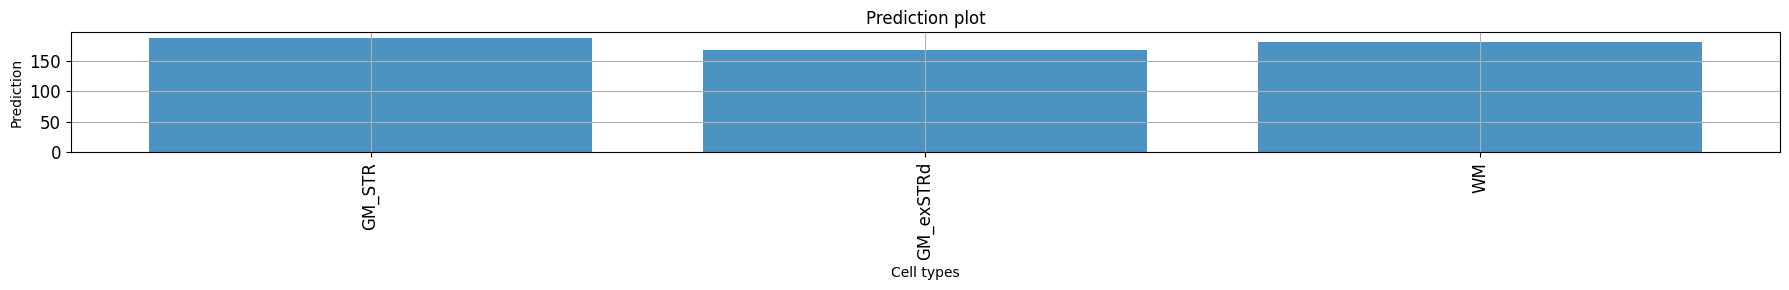

In [15]:
%matplotlib inline
candidates = []

regions = ["chr7:86442158-86444272", "chr7:86303605-86305719",
           "chr12:65015015-65017129", "chr12:64890015-64892129","chr12:64997303-64999417"
          "chr5:151744445-151746558", "chr5:151723445-151725558", "chr5:151739530-151741642"]
idx=4
region=regions[idx]
chrom = region.split(':')[0]
start = int(region.split(':')[1].split('-')[0])
end=start+2114
sequence = genome.fetch(chrom, start, end)
prediction = crested.tl.predict(sequence, model)

crested.pl.bar.prediction(prediction, classes=list(adata.obs_names), x_label_rotation=90)

In [16]:
classes_of_interest = ['GM_STR', 'GM_exSTRd', 'WM']
class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,  # None (=all classes), list of target indices, or empty list (='combined' class)
    model=model,
    method="integrated_grad",  # default. Other options: "integrated_grad", "mutagenesis"
)

2025-08-06T11:16:16.322499-0700 INFO Calculating contribution scores for 3 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


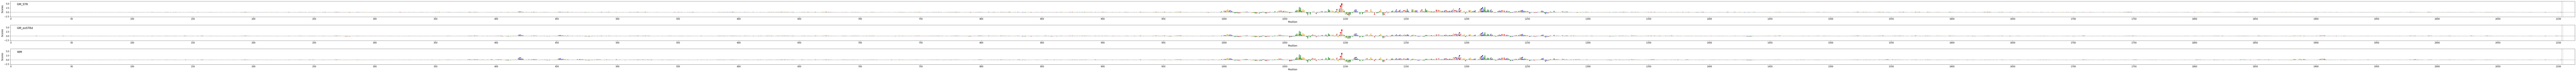

In [23]:
chrom = "chr12"
start=65015015
end = 65017129
pos_list_rel=None
pos_list = [65015473, 65018638]
pos_rel = [(pos-start, pos-start+1) for pos in pos_list]

chrom = "chr12"
start=64997303
end = 64999417
pos_list = [64999406]
pos_list_rel = [(pos-start, pos-start+1) for pos in pos_list]

crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[""],
    class_labels=classes_of_interest,
    zoom_n_bases=2114,
    title="",
    highlight_positions=pos_list_rel,
    #save_path="WIF_enhancer.pdf"
)  # zoom in on the center 500bp

# Gene locus scoring

In [44]:
chrom = "chr12"
start= 65050626
end= 65121305

cell_type = "GM_STR"
class_idx = list(adata.obs_names).index(cell_type)

upstream=5000
downstream=50000

strand= '-'

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

2025-07-30 17:08:50.888730: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 467.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-30 17:08:51.411180: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 203.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-30 17:08:53.262386: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-30 17:08:56.673789: W external/local_xla/x

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [45]:
bigwig = bigwigs_folder +'/'+ cell_type + ".bw"

values = (
    crested.utils.read_bigwig_region(
        bigwig, (chrom, start - upstream, end + downstream)
    )
    if strand == "+"
    else crested.utils.read_bigwig_region(
        bigwig, (chrom, start - downstream, end + upstream)
    )
)
bw_values = values[0]
midpoints = values[1]

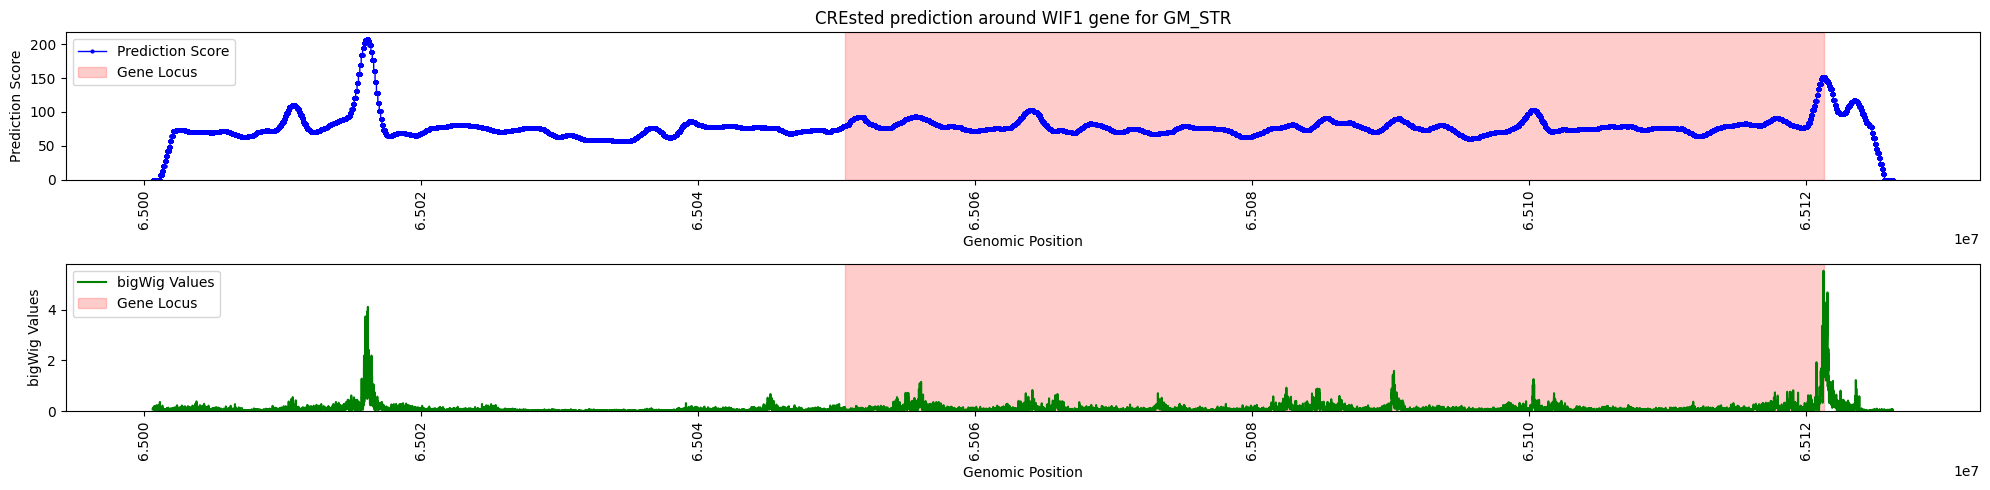

In [46]:
%matplotlib inline
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around WIF1 gene for " + cell_type,
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
    grid=False,
    figsize=(20, 5),
    marker_size=2,
    line_width=1,
)